# Natural Language Processing

Ce script est destiné à pré traiter et analyser les données textuelles i.e les titres et commentaires de df.

In [2]:
import fastparquet
import pyarrow
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
#vis

## Ouverture du fichier 

In [3]:
# Définition du dossier data
folder_path = r'C:\Users\romai\Projets ML\natural_surf_lodge\data'

review_path = folder_path + '\df_reviews.parquet'

<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-3-1de5a676b341>:4: DeprecationWarning: invalid escape sequence \d
  review_path = folder_path + '\df_reviews.parquet'


In [4]:
df = pd.read_parquet(review_path)

df.head()

date  note                               titre  \
0 2023-08-01   5.0                Natural Surf Lodge❤️   
1 2023-08-01   5.0                     Super Surf Camp   
2 2023-08-01   5.0  surf, détente naturelle et partage   
3 2023-08-01   5.0                    C’était génial !   
4 2023-07-01   5.0              Je veux y retourner!!!   

                                         commentaire cle_html_dict  annee  \
0  Des vacances exceptionnelles dans un endroit e...             1   2023   
1  Super Surf camp! une très bonne ambiance pour ...             1   2023   
2  Venue pour la 4eme fois, j'ai de nouveau passé...             1   2023   
3  Là pour une semaine ado en tipi; Très bien acc...             1   2023   
4  C'est le meilleur stage de surf que j'ai fais....             1   2023   

   mois  jour  
0     8     1  
1     8     1  
2     8     1  
3     8     1  
4     7     1

## Analyses descriptives 

In [5]:
print(f"Nombre de reviews : {len(df)}")
df['commentaire'] = df['commentaire'].str.strip()  # Retirer les espaces en début ou fin de commentaire, pour aussi retirer les commentaires de type "  "
df = df[df['commentaire'] != ""]
print(f"Nombre de reviews avec un commentaire : {len(df)}")

Nombre de reviews : 926
Nombre de reviews avec un commentaire : 926


### Le mois

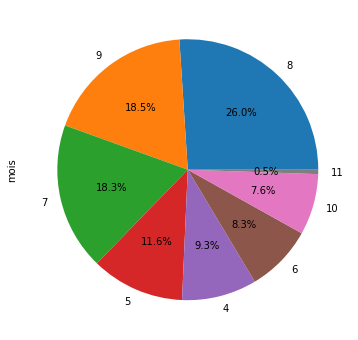

In [6]:
# Pourcentage d'avis selon le mois
plt.figure(figsize=(9,6))
df['mois'].value_counts(normalize=True).plot.pie(autopct="%.1f%%")
plt.show()

Est-ce qu'on observe un changement dans cette distribution selon les années ?

In [7]:
annees = df['annee'].unique()
annees

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2009,
       2011], dtype=int64)

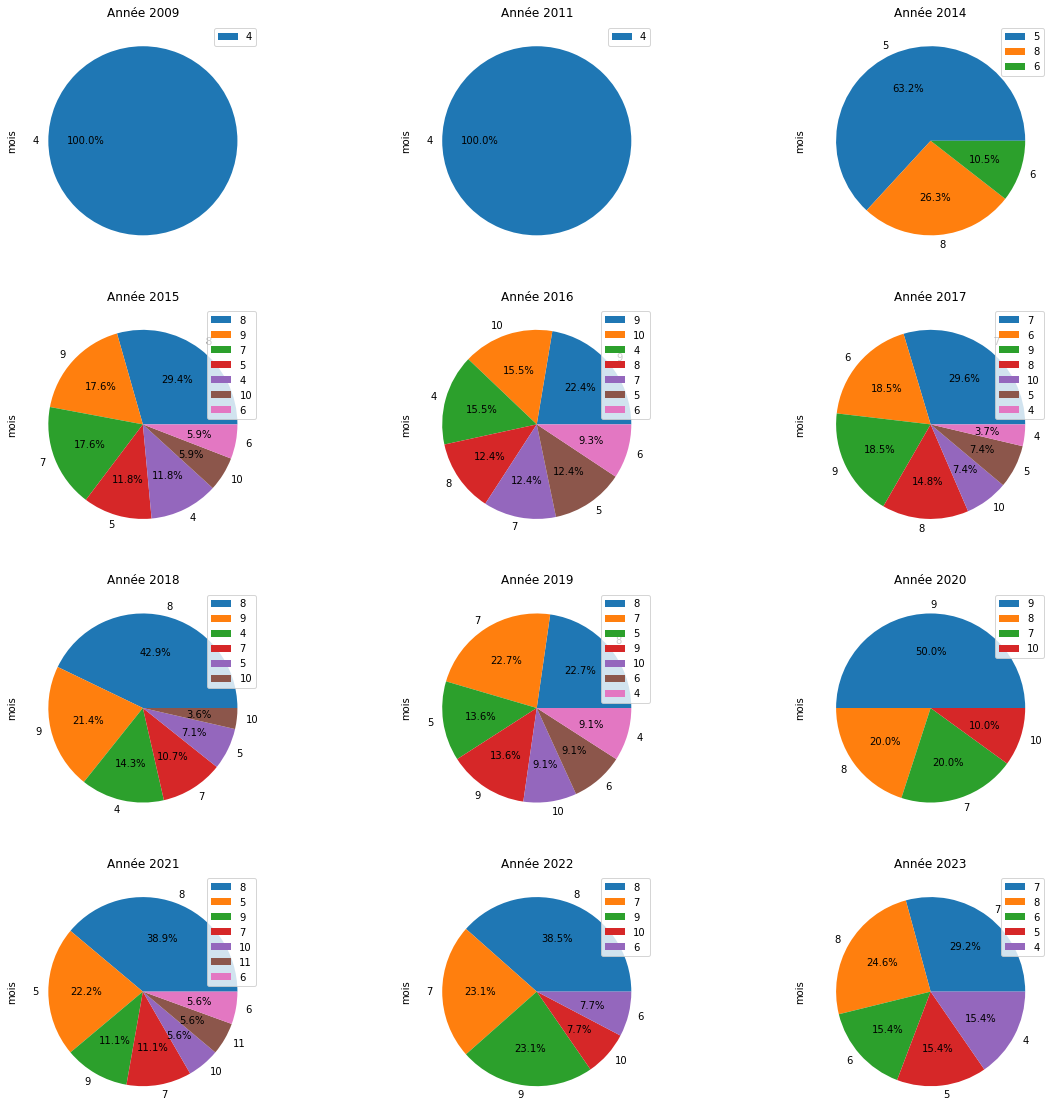

In [8]:
fig = plt.figure(figsize = (20,20))
annees = sorted(df['annee'].unique())

for i, an in zip(range(12), annees)  : 
    ax = fig.add_subplot(4,3, i+1)
    df_plot = df[df['annee'] == an]
    ax = df_plot['mois'].value_counts(normalize=True).plot.pie(autopct="%.1f%%")
    ax.set_title(f'Année {an}')
    ax.set_label(annees)
    plt.legend(loc='best')

### Les notes sur 5

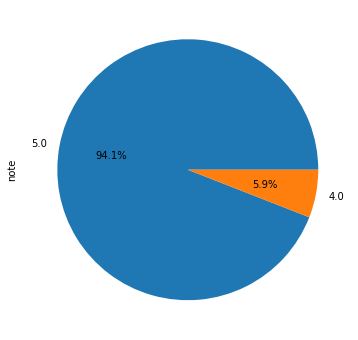

In [9]:
# Répartition des notes
plt.figure(figsize=(9,6))
df['note'].value_counts(normalize=True, sort=False).plot.pie(autopct="%.1f%%")
plt.show()

Il y a 95% de 5 sur 5. 

Et par an ? 

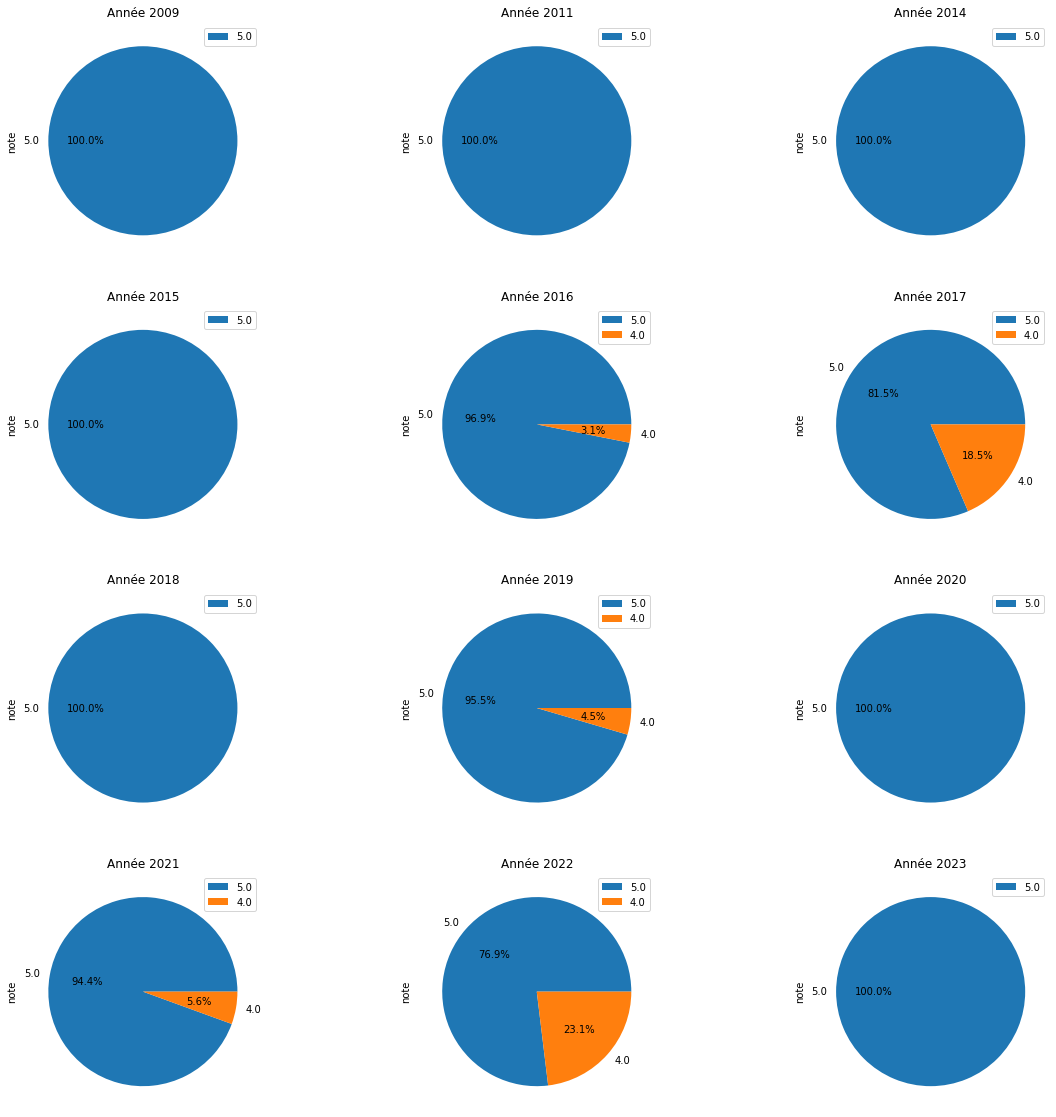

In [10]:
fig = plt.figure(figsize = (20,20))
annees = sorted(df['annee'].unique())

for i, an in zip(range(12), annees)  : 
    ax = fig.add_subplot(4,3, i+1)
    df_plot = df[df['annee'] == an]
    ax = df_plot['note'].value_counts(normalize=True).plot.pie(autopct="%.1f%%")
    ax.set_title(f'Année {an}')
    ax.set_label(annees)
    plt.legend(loc='best')

### Les avis

Text(0.5, 1.0, 'Avis scrappé par mois')

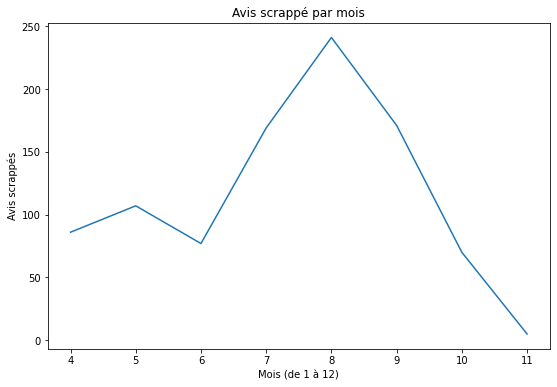

In [11]:
# On compte les avis par mois
fig = plt.figure(figsize = (9,6))
plt.title('Avis par mois')
plt.xlabel('Mois (de 1 à 12)')
plt.ylabel('Avis scrappés')
plt.plot(df.groupby(['mois'])['commentaire'].size())
plt.title('Avis scrappé par mois')

Text(0.5, 1.0, 'Avis scrappé par année')

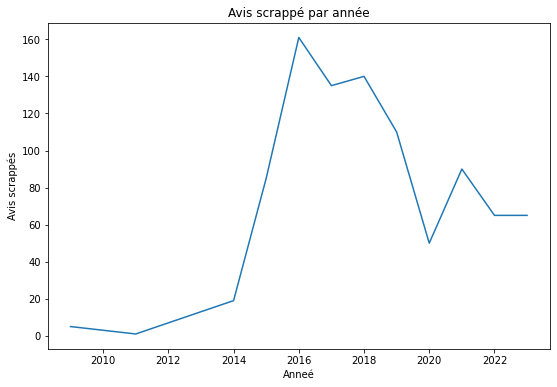

In [12]:
# Les avis par année
fig = plt.figure(figsize = (9,6))
plt.title('Avis par année')
plt.xlabel('Anneé')
plt.ylabel('Avis scrappés')
plt.plot(df.groupby(['annee'])['commentaire'].size())
plt.title('Avis scrappé par année')

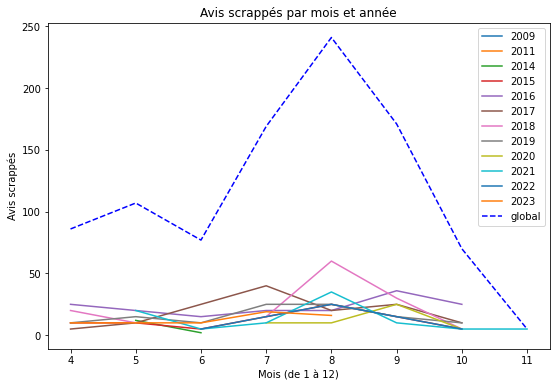

In [13]:
# Evolution des avis par mois, groupés par année
annees = sorted(df['annee'].unique())

fig = plt.figure(figsize = (9,6))
plt.title('Avis scrappés par mois et année')
plt.xlabel('Mois (de 1 à 12)')
plt.ylabel('Avis scrappés')

for i in annees : 
    avis_par_mois_annee = df.groupby(['mois', 'annee']).size().unstack()
    df_plot = avis_par_mois_annee[i]
    plt.plot(df_plot, label = i)

plt.plot(df.groupby(['mois'])['commentaire'].size(), '--', label = 'global', color = 'blue')
plt.legend(loc = 'upper right')

## Exploration des données

On ajoute une ligne sur la longueur du commentaire. 

In [5]:
df['longueur_comment'] = df['commentaire'].str.len() 
df.head()

date  note                               titre  \
0 2023-08-01   5.0                Natural Surf Lodge❤️   
1 2023-08-01   5.0                     Super Surf Camp   
2 2023-08-01   5.0  surf, détente naturelle et partage   
3 2023-08-01   5.0                    C’était génial !   
4 2023-07-01   5.0              Je veux y retourner!!!   

                                         commentaire cle_html_dict  annee  \
0  Des vacances exceptionnelles dans un endroit e...             1   2023   
1  Super Surf camp! une très bonne ambiance pour ...             1   2023   
2  Venue pour la 4eme fois, j'ai de nouveau passé...             1   2023   
3  Là pour une semaine ado en tipi; Très bien acc...             1   2023   
4  C'est le meilleur stage de surf que j'ai fais....             1   2023   

   mois  jour  longueur_comment  
0     8     1               623  
1     8     1               749  
2     8     1               851  
3     8     1               217  
4     7     1               212

### Boxplot sur la longueur des commentaires

C:\Users\romai\anaconda3\lib\site-packages\seaborn\categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\romai\anaconda3\lib\site-packages\seaborn\utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


Text(0, 0.5, '')

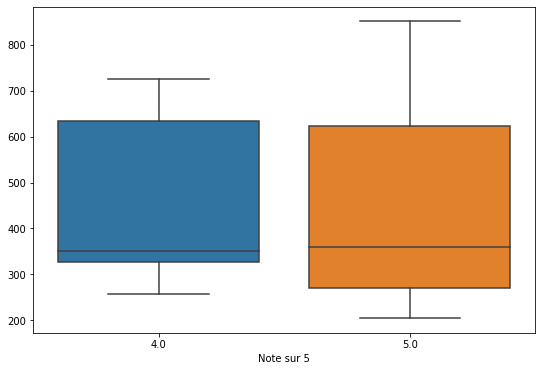

In [15]:
fig = plt.figure(figsize = (9,6))
sns.boxplot(data = df, x = 'note', y = 'longueur_comment')
plt.xlabel('Note sur 5')
plt.ylabel('')

C:\Users\romai\anaconda3\lib\site-packages\seaborn\distributions.py:179: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, np.float)
C:\Users\romai\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:484: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)


Text(0, 0.5, '')

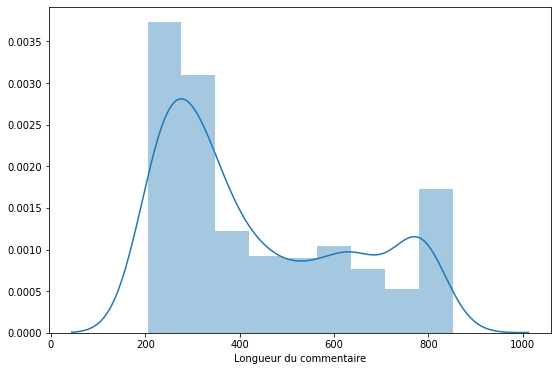

In [16]:
# On peut regarder la distribution de la longueur des commentaires
fig = plt.figure(figsize = (9,6))
sns.distplot(df['longueur_comment'])
plt.xlabel('Longueur du commentaire')
plt.ylabel('')

### Part de ponctuation 

In [6]:
def compte_majuscules(commentaire):
    if len(commentaire) == 0 :
        return 0
    else :
        r = re.compile("[A-Z]")  # Regex qui match toute majuscule
        capslock = r.findall(commentaire)  # Compte le nombre de majuscules dans le texte
        return len(capslock) / len(commentaire)  # Normalisation par la longueur du texte

def compte_points_exclamation(commentaire):
    if len(commentaire) == 0 :
        return 0
    else :   
        r = re.compile("\!")  # Regex qui match tout point d'exclamation
        exclamation = r.findall(commentaire)  # Compte le nombre de points d'exclamation dans le texte
        return len(exclamation) / len(commentaire)  # Normalisation par la longueur du texte

def strip_emoji(commentaire):
    if len(commentaire) == 0 :
        return 0
    else :
        r = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE) # Regex qui match les emojis
        emojis = r.findall(commentaire) # compte le nombre d'emojis dans le texte
        return len(emojis) / len(commentaire) # part d'emojis dans le texte

df['part_majuscules'] = df['commentaire'].apply(compte_majuscules)
df['part_points_exclamation'] = df['commentaire'].apply(compte_points_exclamation)
df['part_emojis'] = df['commentaire'].apply(strip_emoji)

<>:13: DeprecationWarning: invalid escape sequence \!
<>:13: DeprecationWarning: invalid escape sequence \!
<>:13: DeprecationWarning: invalid escape sequence \!
<ipython-input-6-54de93ef84b9>:13: DeprecationWarning: invalid escape sequence \!
  r = re.compile("\!")  # Regex qui match tout point d'exclamation


In [18]:
df['part_emojis'].value_counts()

0.000000    896
0.018293      5
0.011628      5
0.005000      5
0.004202      5
0.006042      5
0.002532      5
Name: part_emojis, dtype: int64

La présence d'emojis est faible et semble être un critère peu pertinent pour les analyses. 

C:\Users\romai\anaconda3\lib\site-packages\seaborn\categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\romai\anaconda3\lib\site-packages\seaborn\utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


Text(0.5, 1.0, 'Violin plot de la part de majuscules')

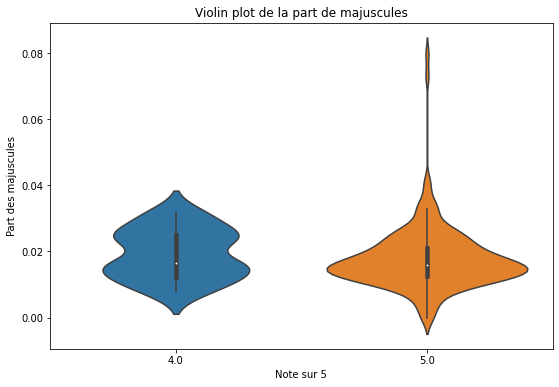

In [19]:
plt.figure(figsize=(9,6))
sns.violinplot(data = df, x='note', y='part_majuscules')
plt.xlabel('Note sur 5')
plt.ylabel('Part des majuscules')
plt.title("Violin plot de la part de majuscules")

C:\Users\romai\anaconda3\lib\site-packages\seaborn\categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\romai\anaconda3\lib\site-packages\seaborn\utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


Text(0.5, 1.0, "Violin plot de la part de points d'exclamation")

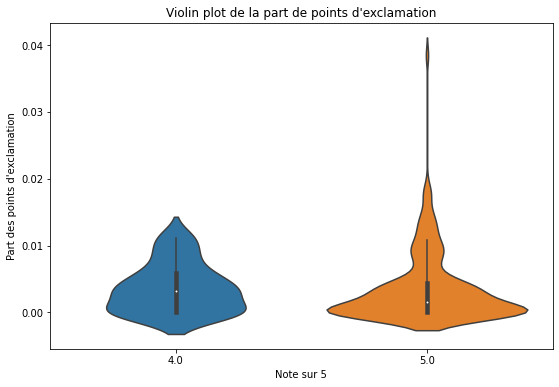

In [20]:
plt.figure(figsize=(9,6))
sns.violinplot(data = df, x='note', y='part_points_exclamation')
plt.xlabel('Note sur 5')
plt.ylabel("Part des points d'exclamation")
plt.title("Violin plot de la part de points d'exclamation")

C:\Users\romai\anaconda3\lib\site-packages\seaborn\categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\romai\anaconda3\lib\site-packages\seaborn\utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


Text(0.5, 1.0, "Violin plot de la part d'emojis")

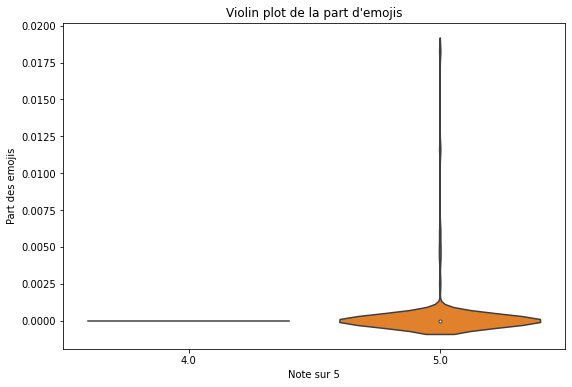

In [21]:
plt.figure(figsize=(9,6))
sns.violinplot(data = df, x='note', y='part_emojis')
plt.xlabel('Note sur 5')
plt.ylabel("Part des emojis")
plt.title("Violin plot de la part d'emojis")

 ## Nettoyage et pré-traitement

### Suppression des espaces et des carcatères ASCII

In [7]:
df['commentaire'] = df['commentaire'].str.lower()
df['commentaire'] = df['commentaire'].apply(unidecode)

### Utilisation de SpaCy

In [ ]:
!python -m spacy download fr_core_news_md

On stock dans un objet spacy. 

In [8]:
import fr_core_news_md

In [9]:
nlp = spacy.load("fr_core_news_md")

In [25]:
pipe = nlp.pipe(df['commentaire'], n_process=5,
                disable=["tagger", "parser", "attribute_ruler", "ner"])

On tokenize puis on trie les mots en les mettant sous forme canonique neutre. 

In [26]:
def preprocess_token(token):
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        return token.lemma_
    else:
        return ""

def preprocess_text(text_nlp):
    text_pretraite_list = [preprocess_token(token) for token in text_nlp if token]
    text_pretraite = " ".join(text_pretraite_list)
    return text_pretraite

commentaires_pretraites = [preprocess_text(commentaire) for commentaire in pipe]

In [27]:
df['commentaire_pretraite'] = commentaires_pretraites

In [28]:
df.head()

date  note                               titre  \
0 2023-08-01   5.0                Natural Surf Lodge❤️   
1 2023-08-01   5.0                     Super Surf Camp   
2 2023-08-01   5.0  surf, détente naturelle et partage   
3 2023-08-01   5.0                    C’était génial !   
4 2023-07-01   5.0              Je veux y retourner!!!   

                                         commentaire cle_html_dict  annee  \
0  des vacances exceptionnelles dans un endroit e...             1   2023   
1  super surf camp! une tres bonne ambiance pour ...             1   2023   
2  venue pour la 4eme fois, j'ai de nouveau passe...             1   2023   
3  la pour une semaine ado en tipi; tres bien acc...             1   2023   
4  c'est le meilleur stage de surf que j'ai fais....             1   2023   

   mois  jour  longueur_comment  part_majuscules  part_points_exclamation  \
0     8     1               623         0.008026                 0.000000   
1     8     1               747         0.014726                 0.010710   
2     8     1               851         0.009401                 0.001175   
3     8     1               217         0.023041                 0.000000   
4     7     1               208         0.019231                 0.009615   

   part_emojis                              commentaire_pretraite  
0          0.0   vacance exceptionnel   endroit exceptionnel  ...  
1          0.0  super surf camp    bon ambiance   voyageur sol...  
2          0.0  venir    fois      passer  semaine  fantastiqu...  
3          0.0     semaine ado  tipi   bien accueillir  encadr...  
4          0.0     meilleur stage  surf        vraiment hate  ...

### Enregistrement au format parquet 

In [29]:
# Définition des chemins
dir_path = 'C:\\Users\\romai\\Projets ML\\natural_surf_lodge'
data_path = dir_path + '\data'

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-29-15b8ee42149e>:3: DeprecationWarning: invalid escape sequence \d
  data_path = dir_path + '\data'


In [30]:
# Export dans les chemins définis
path_df_review = data_path + '/df_ml.parquet'
df.to_parquet(path = path_df_review)

## Analyse textuelle des commentaires 

In [12]:
# Les path
dir_path = 'C:\\Users\\romai\\Projets ML\\natural_surf_lodge'
data_path = dir_path + '\data'
path_df_review = data_path + '/df_ml.parquet'

df = pd.read_parquet(path_df_review)

df.head()

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-12-323421dea465>:3: DeprecationWarning: invalid escape sequence \d
  data_path = dir_path + '\data'


date  note                               titre  \
0 2023-08-01   5.0                Natural Surf Lodge❤️   
1 2023-08-01   5.0                     Super Surf Camp   
2 2023-08-01   5.0  surf, détente naturelle et partage   
3 2023-08-01   5.0                    C’était génial !   
4 2023-07-01   5.0              Je veux y retourner!!!   

                                         commentaire cle_html_dict  annee  \
0  des vacances exceptionnelles dans un endroit e...             1   2023   
1  super surf camp! une tres bonne ambiance pour ...             1   2023   
2  venue pour la 4eme fois, j'ai de nouveau passe...             1   2023   
3  la pour une semaine ado en tipi; tres bien acc...             1   2023   
4  c'est le meilleur stage de surf que j'ai fais....             1   2023   

   mois  jour  longueur_comment  part_majuscules  part_points_exclamation  \
0     8     1               623         0.008026                 0.000000   
1     8     1               747         0.014726                 0.010710   
2     8     1               851         0.009401                 0.001175   
3     8     1               217         0.023041                 0.000000   
4     7     1               208         0.019231                 0.009615   

   part_emojis                              commentaire_pretraite  
0          0.0   vacance exceptionnel   endroit exceptionnel  ...  
1          0.0  super surf camp    bon ambiance   voyageur sol...  
2          0.0  venir    fois      passer  semaine  fantastiqu...  
3          0.0     semaine ado  tipi   bien accueillir  encadr...  
4          0.0     meilleur stage  surf        vraiment hate  ...

## Nuage de mots 

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926 entries, 0 to 4
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     926 non-null    datetime64[ns]
 1   note                     926 non-null    float64       
 2   titre                    926 non-null    object        
 3   commentaire              926 non-null    object        
 4   cle_html_dict            926 non-null    object        
 5   annee                    926 non-null    int64         
 6   mois                     926 non-null    int64         
 7   jour                     926 non-null    int64         
 8   longueur_comment         926 non-null    int64         
 9   part_majuscules          926 non-null    float64       
 10  part_points_exclamation  926 non-null    float64       
 11  part_emojis              926 non-null    float64       
 12  commentaire_pretraite    926 non-null 

On veut réaliser un nuage de mots i.e afficher sur un grapphique les mots qui reviennent le plus souvent. 

In [15]:
corpus_cleaned_comments = ' '.join(df['commentaire_pretraite'])  # Concaténer tout le corpus en une chaîne de caractères

In [29]:
corpus_cleaned_comments

' vacance exceptionnel   endroit exceptionnel   equipe  top  matin  soir          impression     sejour  paradis      aimer    bel rencontre   surf   environnement revigorant   sortir   apaiser   lodge   eden   paradis  nature   surf devenir vite  nouveau religion    tombe amoureux   region    sejour  lodge           habiter  seignosse   venir   passer   semaine  vacance        lodge  definitivement  incontournable  super surf camp    bon ambiance   voyageur solo    famille   endroit   magique   nature     min  voiture   plage   chambre  propre   literie  top    petit déjeuner copieux    dela   bon ambiance  prof  surf  hyper competent  chercher   faire progresser  petit groupe   nanook        avoir    energie  pouvoir emprunter planche  combinaison  continuer       spot  loin  plage bondee   cote basque  ici       eau     prendre  maximum  vague     vraiment  ambiance familial   aimer revenir  annee    clair  hugo   super energie  venir    fois      passer  semaine  fantastique   cour

In [ ]:
corpus_cleaned_comments = ' '.join(df['comment_pretraite'])  # Concaténer tout le corpus en une chaîne de caractères
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus_cleaned_comments)  # Créer le nuage de mots

In [ ]:
# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Countplot 

In [ ]:
# Vectorisation du texte
texts = df["comment_pretraite"]

vectorizer = CountVectorizer()
vectorizer.fit(texts)

vocab = vectorizer.get_feature_names_out()

texts_vectorized = vectorizer.transform(texts)
texts_vectorized

In [ ]:
texts_vectorized = texts_vectorized.toarray() # Economie de stockage

In [ ]:
# Fréquence de chaque mot avec une somme 'verticale'
texts_vectorized.sum(axis = 0)

# Association mot et fréquence : dictionnaire
dic_freq = {}
for ind, word in zip(range(1, texts_vectorized.sum(axis = 0).shape[0]), vocab):
    dic_freq[word] = texts_vectorized.sum(axis = 0)[ind-1]

In [ ]:
# Comptage du vocabulaire
df_compt_voc = pd.DataFrame(dic_freq.items(), columns = ['mot', 'comptage']).sort_values('comptage', ascending = False)

df_compt_voc.head()

In [ ]:
# Fonction qui permet de réaliser des countplot
def plot_freq_n_grammes(commentaires, ngram_range=(1,1), n_results=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    vectorizer.fit(commentaires)
    vocab = vectorizer.get_feature_names_out()
    
    comptages = np.array(vectorizer.transform(commentaires).sum(0))[0]
    comptages_voc = list(zip(vocab, comptages))
    comptages_voc = sorted(comptages_voc, key=lambda x: x[1], reverse=True)
    comptages_voc = pd.DataFrame(comptages_voc, columns=['mot', 'frequence'])  
    
    return comptages_voc.head(n_results)

On peut alors représenter très simplement les fréquences des n premiers mots du corpus :

In [ ]:
df_compt_voc = plot_freq_n_grammes(commentaires = df_nlp['comment_pretraite'], ngram_range=(1,1), n_results=10)

sns.barplot(x='frequence', y='mot', data=df_compt_voc.head(10))

In [ ]:
texts = df_nlp[df_nlp["note"] == 1]["comment_pretraite"]

comptages_3_3 = plot_freq_n_grammes(commentaires=texts, 
                                    ngram_range=(3,3), 
                                    n_results=10)

sns.barplot(x="frequence", y="mot", data=comptages_3_3) # Seaborn selon les suite de trois mots revenant le plus 